In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def loadSimpData():  # 读取数据集与对应的标签
    datMat = np.array([[1., 2.1],
                       [2., 1.1],
                       [1.3, 1.],
                       [1., 1.],
                       [2., 1.],
                       [1.8, 1.6],
                       [1.2, 1.2],
                       [1.9, 1.7]])
    classLabels = np.array([1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1.0])
    return datMat, classLabels

In [3]:
def loadDataSet(fileName):
    numFeat = len(open(fileName).readline().split('\t'))  # 通过分隔符分割数据
    dataMat = []  # 新建一个矩阵
    labelMat = []
    fr = open(fileName)  # 打开文件
    for line in fr.readlines():  # 读入每行的数据
        lineArr = []
        curLine = line.strip().split('\t')  # 通过分隔符分割数据
        for i in range(numFeat - 1):
            lineArr.append(float(curLine[i]))  # 将样本的属性存入lineArr
        dataMat.append(lineArr)  # 将所有样本的属性存入dataMat
        labelMat.append(float(curLine[-1]))  # 提取每行数据的标签
    return dataMat, labelMat

In [4]:
def stumpClassify(dataMatrix, dimen, threshVal, threshIneq):  # just classify the data
    retArray = np.ones((np.shape(dataMatrix)[0], 1)) # 创建一个和dataMatrix
    if threshIneq == 'lt':
        # 使该列中值小于或等于阈值的点类别为-1.0，其他为1.0
        retArray[dataMatrix[:, dimen] <= threshVal] = -1.0
    else:
        # 使该列中值大于阈值的点类别为-1.0，其他为1.0
        retArray[dataMatrix[:, dimen] > threshVal] = -1.0
    return retArray

In [5]:
def buildStump(dataArr, classLabels, D):
    dataMatrix = np.mat(dataArr)
    labelMat = np.mat(classLabels).T  # 转置标签向量
    m, n = np.shape(dataMatrix)  # 样本的行数列数
    numSteps = 10.0  # 初始化步数
    bestStump = {}  # 初始化决策树
    bestClasEst = np.mat(np.zeros((m, 1)))  # 默认类别为0
    minError = np.inf  # 初始化错误为无穷大
    for i in range(n):  # 遍历数据所有属性
        rangeMin = dataMatrix[:, i].min()  # 在当前属性中选取最小值
        rangeMax = dataMatrix[:, i].max()  # 在当前属性中选取最大值
        stepSize = (rangeMax - rangeMin) / numSteps  # 给定步数 计算步长
        for j in range(-1, int(numSteps) + 1):  # 在当前维度内循环步数次
            for inequal in ['lt', 'gt']:  # 对值小于threshVal时分类分为为1.0还是-1.0两种情况进行遍历
                threshVal = (rangeMin + float(j) * stepSize)  # 计算划分值threshVal
                predictedVals = stumpClassify(dataMatrix, i, threshVal, inequal)  # 得到分类结果
                errArr = np.mat(np.ones((m, 1)))  # errArr默认为全1矩阵
                errArr[predictedVals == labelMat] = 0  # 比对分类结果与标签进行 分类正确为0 错误为1
                weightedError = D.T * errArr  # 计算加权后的误差
                if weightedError < minError:  # 如果误差值小于最小误差
                    minError = weightedError  # 则更新最小误差为当前误差
                    bestClasEst = predictedVals.copy()  # 更新分类结果
                    # 更新最佳的决策树为当前信息
                    bestStump['dim'] = i  # i表示是以第1列还是第2列为分类依据
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal  # inequal决定值小于threshVal分类为-1.0还是1.0
    return bestStump, minError, bestClasEst

In [31]:
def adaBoostTrainDS(dataArr, classLabels, numIt=100):
    weakClassArr = []  # 建立一个矩阵用于存放基学习器
    m = np.shape(dataArr)[0]
    D = np.mat(np.ones((m, 1)) / m)  # 初始化权值为1/m
    aggClassEst = np.mat(np.zeros((m, 1)))
    for i in range(numIt):
        bestStump, error, classEst = buildStump(dataArr, classLabels, D)  # 调用buildStump函数 建立决策树
        # 通过alpha的更新公式计算alpha
        alpha = float(0.5 * np.log((1.0 - error) / max(error, 1e-16)))
        bestStump['alpha'] = alpha
        weakClassArr.append(bestStump)  # 在数组中存放基学习器的信息
        # 计算自然底数幂次项
        expon = np.multiply(-1 * alpha * np.mat(classLabels).T, classEst)
        D = np.multiply(D, np.exp(expon))  # 更新权值D
        D = D / D.sum()  # 对新计算出的D进行归一化操作(即公式中/z)
        aggClassEst += alpha * classEst  # 计算更新后的分类结果

        aggErrors = np.multiply(np.sign(aggClassEst) != np.mat(classLabels).T, np.ones((m, 1)))
        errorRate = aggErrors.sum() / m
        if m >= 50:
            if i % 10 == 0 and i != 0:
                print("total error: ", errorRate, "({} / {})".format(i, numIt))
        else:
            print("total error: ", errorRate)
        if errorRate == 0.0:  # 如果错误率为0则直接跳出循环节省时间
            break 
    return weakClassArr, aggClassEst

In [32]:
def adaClassify(datToClass, labels, classifierArr):
    dataMatrix = np.mat(datToClass)  # do stuff similar to last aggClassEst in adaBoostTrainDS
    m = np.shape(dataMatrix)[0]
    aggClassEst = np.mat(np.zeros((m, 1)))
    for i in range(len(classifierArr)):
        classEst = stumpClassify(  # 调用stumpClassify函数进行预测
            dataMatrix,
            classifierArr[i]['dim'],  # 读入维度
            classifierArr[i]['thresh'],  # 读入阈值
            classifierArr[i]['ineq']  # 读入与阈值的大小关系
        )
        aggClassEst += classifierArr[i]['alpha'] * classEst  # 更新alpha值并累加至aggClassEst
    # 比对预测出类别与标签的差别 计算错误个数
    aggErrors = np.multiply(np.sign(aggClassEst) != np.mat(labels).T, np.ones((m, 1)))
    errorRate = aggErrors.sum() / m  # 计算错误率
    print("test error: ", errorRate)
    return np.sign(aggClassEst)  # 返回aggClassEst的符号值 即为预测的类别

In [33]:
def plotThis(dataMat, classLabels, weakClassArr):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    classLabels = np.array(classLabels)
    dataMat = np.array(dataMat)
    L1 = np.where(classLabels == 1)
    p1 = ax1.scatter(dataMat[L1, 0], dataMat[L1, 1], marker='+', color='r', label='1', s=50)
    L2 = np.where(classLabels == -1)
    p2 = ax1.scatter(dataMat[L2, 0], dataMat[L2, 1], marker='o', color='b', label='-1', s=50)

    for i in range(len(weakClassArr)):
        if weakClassArr[i]['dim'] == 0:
            ax1.axvline(x=weakClassArr[i]['thresh'], c="k", lw=2)
        if weakClassArr[i]['dim'] == 1:
            ax1.axhline(y=weakClassArr[i]['thresh'], c="k", lw=2)
    plt.ylabel('y-value')
    plt.xlabel('x-value')
    plt.show()

In [34]:
sampleMat, sampleLabel = loadSimpData()
sampleArr, _ = adaBoostTrainDS(sampleMat, sampleLabel)

total error:  0.125
total error:  0.125
total error:  0.125
total error:  0.125
total error:  0.0


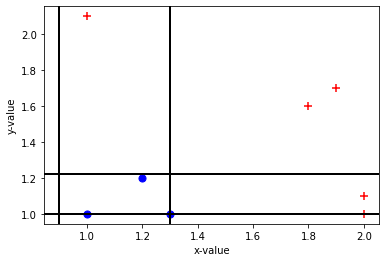

In [35]:
plotThis(sampleMat, sampleLabel, sampleArr)

In [36]:
trainMat, trainLabel = loadDataSet('horseColicTraining2.txt')
weakClassArr, _ = adaBoostTrainDS(trainMat, trainLabel)
testMat, testLabel = loadDataSet('horseColicTest2.txt')
adaClassify(testMat, testLabel, weakClassArr)

total error:  0.2408026755852843 (10 / 100)
total error:  0.2140468227424749 (20 / 100)
total error:  0.21070234113712374 (30 / 100)
total error:  0.20066889632107024 (40 / 100)
total error:  0.1939799331103679 (50 / 100)
total error:  0.1939799331103679 (60 / 100)
total error:  0.19063545150501673 (70 / 100)
total error:  0.18394648829431437 (80 / 100)
total error:  0.18394648829431437 (90 / 100)
test error:  0.22388059701492538


matrix([[ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 